# 📦 1. Preparación del Dataset

En esta sección se construyen los **dataset base:** a partir de 8 videos de entrada (4 para Entrenamiento/Validación y 4 para test), cada uno correspondiente a una etiqueta (*label*) distinta.

## 📋 **Proceso resumido**:
1. **Extracción de coordenadas** usando [MediaPipe Pose](https://ai.google.dev/edge/mediapipe/solutions/vision/pose_landmarker?hl=es-419) para identificar los **33 puntos clave del cuerpo**.
2. Cada punto proporciona **3 coordenadas** `(x, y, z)`, generando así **99 columnas** por frame, más **1 columna de etiqueta**.
3. Se procesan los videos de manera individual, guardando un **CSV por etiqueta**.
4. Finalmente, Para *train_val* y *test* se **unen los 4 CSVs** en un único archivo, listo para cargarse con **Pandas**.

## 💻 **Implementación**:
- Todo el proceso se encuentra encapsulado en la clase `Preparar_dataset`
- Principales métodos:
  - `Crea_carpetas()` → Genera la estructura de carpetas de trabajo.
  - `Extrae_frames()` → Extrae frames y coordenadas de cada video.
  - `une_csvs()` → Une los CSV individuales en un único ***dataset_completo.csv***.


In [1]:
from scripts.Preparar_dataset import Preparar_dataset
dataset=Preparar_dataset()
dataset.Crea_carpetas()
dataset.Extrae_frames()
dataset.une_csvs()

2025-08-10 03:05:05.942812: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-08-10 03:05:05.950661: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1754816705.959742   85523 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1754816705.962444   85523 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1754816705.969757   85523 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

/home/misa/GitHub/Timeless-Turing/data/processed_videos/train_val/OTRO.mp4 OTRO
/home/misa/GitHub/Timeless-Turing/data/processed_videos/train_val/BRAZOS_CRUZADOS.mp4 BRAZOS_CRUZADOS
/home/misa/GitHub/Timeless-Turing/data/processed_videos/train_val/FIRMES.mp4 FIRMES
/home/misa/GitHub/Timeless-Turing/data/processed_videos/train_val/POSICION_FETAL.mp4 POSICION_FETAL
/home/misa/GitHub/Timeless-Turing/data/processed_videos/test/OTRO.mp4 OTRO
/home/misa/GitHub/Timeless-Turing/data/processed_videos/test/BRAZOS_CRUZADOS.mp4 BRAZOS_CRUZADOS
/home/misa/GitHub/Timeless-Turing/data/processed_videos/test/FIRMES.mp4 FIRMES
/home/misa/GitHub/Timeless-Turing/data/processed_videos/test/POSICION_FETAL.mp4 POSICION_FETAL


Procesando video:  /home/misa/GitHub/Timeless-Turing/data/processed_videos/train_val/OTRO.mp4 con etiqueta OTRO, guardando en /home/misa/GitHub/Timeless-Turing/data/train_val_csv/OTRO.csv


Total de frames: 3216


I0000 00:00:1754816707.188519   85523 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1754816707.251001   85672 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.163.01), renderer: NVIDIA GeForce RTX 4060 Laptop GPU/PCIe/SSE2
INFO: Created TensorFlow Lite XNNPACK delegate for CPU.
W0000 00:00:1754816707.292593   85649 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1754816707.354874   85659 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1754816707.392518   85648 landmark_projection_calculator.cc:186] Using NORM_RECT without IMAGE_DIMENSIONS is only supported for the square ROI. Provide IMAGE_DIMENSIONS or use PROJECTION_MATRIX.


CSV guardado con 536 fotogramas


Procesando video:  /home/misa/GitHub/Timeless-Turing/data/processed_videos/train_val/BRAZOS_CRUZADOS.mp4 con etiqueta BRAZOS_CRUZADOS, guardando en /home/misa/GitHub/Timeless-Turing/data/train_val_csv/BRAZOS_CRUZADOS.csv


Total de frames: 4541


I0000 00:00:1754816729.786565   85523 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1754816729.801994   85738 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.163.01), renderer: NVIDIA GeForce RTX 4060 Laptop GPU/PCIe/SSE2
W0000 00:00:1754816729.841283   85708 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1754816729.909767   85729 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


CSV guardado con 756 fotogramas


Procesando video:  /home/misa/GitHub/Timeless-Turing/data/processed_videos/train_val/FIRMES.mp4 con etiqueta FIRMES, guardando en /home/misa/GitHub/Timeless-Turing/data/train_val_csv/FIRMES.csv


Total de frames: 2124


I0000 00:00:1754816762.022688   85523 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1754816762.061411   85796 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.163.01), renderer: NVIDIA GeForce RTX 4060 Laptop GPU/PCIe/SSE2
W0000 00:00:1754816762.096827   85770 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1754816762.160300   85775 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


CSV guardado con 353 fotogramas


Procesando video:  /home/misa/GitHub/Timeless-Turing/data/processed_videos/train_val/POSICION_FETAL.mp4 con etiqueta POSICION_FETAL, guardando en /home/misa/GitHub/Timeless-Turing/data/train_val_csv/POSICION_FETAL.csv


Total de frames: 2668


I0000 00:00:1754816777.218838   85523 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1754816777.251065   85856 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.163.01), renderer: NVIDIA GeForce RTX 4060 Laptop GPU/PCIe/SSE2
W0000 00:00:1754816777.288127   85827 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1754816777.349660   85842 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


CSV guardado con 440 fotogramas


Procesando video:  /home/misa/GitHub/Timeless-Turing/data/processed_videos/test/OTRO.mp4 con etiqueta OTRO, guardando en /home/misa/GitHub/Timeless-Turing/data/test_csv/OTRO.csv


Total de frames: 2926


I0000 00:00:1754816796.631351   85523 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1754816796.645528   85911 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.163.01), renderer: NVIDIA GeForce RTX 4060 Laptop GPU/PCIe/SSE2
W0000 00:00:1754816796.679846   85881 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1754816796.742414   85905 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


CSV guardado con 487 fotogramas


Procesando video:  /home/misa/GitHub/Timeless-Turing/data/processed_videos/test/BRAZOS_CRUZADOS.mp4 con etiqueta BRAZOS_CRUZADOS, guardando en /home/misa/GitHub/Timeless-Turing/data/test_csv/BRAZOS_CRUZADOS.csv


Total de frames: 2131


I0000 00:00:1754816817.792240   85523 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1754816817.818498   86054 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.163.01), renderer: NVIDIA GeForce RTX 4060 Laptop GPU/PCIe/SSE2
W0000 00:00:1754816817.858574   86022 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1754816817.922113   86033 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


CSV guardado con 354 fotogramas


Procesando video:  /home/misa/GitHub/Timeless-Turing/data/processed_videos/test/FIRMES.mp4 con etiqueta FIRMES, guardando en /home/misa/GitHub/Timeless-Turing/data/test_csv/FIRMES.csv


Total de frames: 2300


I0000 00:00:1754816833.683008   85523 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1754816833.704823   86112 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.163.01), renderer: NVIDIA GeForce RTX 4060 Laptop GPU/PCIe/SSE2
W0000 00:00:1754816833.737648   86082 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1754816833.804768   86085 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


CSV guardado con 383 fotogramas


Procesando video:  /home/misa/GitHub/Timeless-Turing/data/processed_videos/test/POSICION_FETAL.mp4 con etiqueta POSICION_FETAL, guardando en /home/misa/GitHub/Timeless-Turing/data/test_csv/POSICION_FETAL.csv


Total de frames: 1534


I0000 00:00:1754816850.715142   85523 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1754816850.732466   86171 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.163.01), renderer: NVIDIA GeForce RTX 4060 Laptop GPU/PCIe/SSE2
W0000 00:00:1754816850.766421   86141 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1754816850.825840   86158 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


CSV guardado con 242 fotogramas


# 🤖 2. Entrenamiento del Modelo

En esta sección se desarrolla y entrena el **modelo de clasificación** utilizando el dataset previamente preparado.

## 📋 **Flujo del entrenamiento**:
1. **Carga de datos** (`cargar_datos`) → Lee los dataset unificados para *Entrenamiento + Validación* y *Prueba* y lo adapta al formato necesario para el entrenamiento.
2. **División del dataset** (`dividir_datos`) → Separa el dataset en:
   - **Entrenamiento** (*training set*) → Usado para ajustar los pesos del modelo.
   - **Validación** (*validation set*) → Usado para ajustar hiperparámetros y prevenir sobreajuste.
   - **Prueba** (*test set*) → Usado para medir el rendimiento final del modelo.
3. **Construcción de la arquitectura** (`construccion`) → Define las capas de la red neuronal y su configuración.
    
    🧱 Aquí definimos una **red neuronal densa (MLP)** pensada para **datos tabulares** (99 features por frame provenientes de coordenadas `(x,y,z)` de 33 puntos) y **clasificación multiclase**.

    ### 🏗️ Arquitectura
    - **Entrada**: `n_features` (p. ej., 99)  
    - **Bloques densos**:
    - `Dense(128, relu)` → `BatchNormalization()` → `Dropout(0.30)`
    - `Dense(64, relu)` → `BatchNormalization()` → `Dropout(0.30)`
    - **Salida**: `Dense(n_classes, softmax)`
    - **Compilación**: `Adam(lr=1e-3)`, `loss='categorical_crossentropy'`, `metrics=['accuracy']`

    ### 🤔 ¿Por qué esta arquitectura?
    - **Adecuada para tabular**: Las features ya son numéricas y “planas”. Un **MLP** explota bien relaciones no lineales sin necesidad de convoluciones o recorridos temporales.
    - **Capacidad y generalización balanceadas**:
    - **128 → 64 neuronas**: suficiente capacidad para capturar combinaciones entre 99 variables sin sobreparametrizar.
    - **ReLU**: activa solo lo útil, acelera el aprendizaje y evita saturaciones.
    - **Estabilización del entrenamiento**:
    - **BatchNormalization** reduce el *internal covariate shift*, permitiendo tasas de aprendizaje algo más altas y convergencia más estable.
    - **Regularización explícita**:
    - **Dropout(0.30)** en ambos bloques reduce co-adaptaciones y **mitiga el sobreajuste**, importante cuando cada video aporta muchos frames pero con correlaciones fuertes.
    - **Salida softmax + entropía cruzada**:
    - Es el estándar para **multiclase** con **etiquetas one-hot**, produce probabilidades bien calibradas y una función objetivo consistente.

    ### ⚙️ Hiperparámetros clave (y su razonamiento)
    - **Adam (1e-3)**: buen *default* para problemas tabulares; combina momento y adaptación por parámetro.  
    - **Tamaño de capas (128/64)**: escalado empírico típico para 50–200 features. Si observas *underfitting*, prueba 256/128; si hay *overfitting*, baja a 64/32.
    - **Dropout 0.30**: punto intermedio efectivo.
    - **BN + ReLU**: en este diseño BN va **después** de la activación; también es válido poner **BN antes** de la activación (estilo “pre-activation”). Si pruebas esa variante, pon `use_bias=False` en las capas densas.

4. **Entrenamiento** (`entrenamiento`) → Ajusta los pesos usando *training* y valida en cada época con *validation*, guardando el historial de métricas (*accuracy*, *loss*).
5. **Evaluación** (`evaluacion`) → Calcula el rendimiento final sobre el *test set*.
6. **Visualización** (`graficar_entrenamiento`) → Genera gráficas de precisión y pérdida para analizar el comportamiento durante el entrenamiento.

## 💻 **Implementación**:
- El flujo está encapsulado en la clase `Modelo`, ubicada en `scripts/Entrenamiento.py`.
- Permite **reproducir el entrenamiento completo** con una secuencia clara y modular de métodos.


2025-08-10 03:59:39.301851: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-08-10 03:59:39.309475: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1754819979.319194  117979 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1754819979.322039  117979 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1754819979.329374  117979 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

Epoch 1/100


I0000 00:00:1754819981.673133  118137 service.cc:152] XLA service 0x7578f400e130 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1754819981.673146  118137 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce RTX 4060 Laptop GPU, Compute Capability 8.9
2025-08-10 03:59:41.691320: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1754819981.793339  118137 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1754819983.262933  118137 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
2025-08-10 03:59:43.892376: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1496', 140 bytes spill stores, 140 bytes spill loads



7/7 - 4s - 601ms/step - accuracy: 0.4958 - loss: 1.3559 - val_accuracy: 0.4005 - val_loss: 1.3236
Epoch 2/100
7/7 - 0s - 15ms/step - accuracy: 0.7428 - loss: 0.7234 - val_accuracy: 0.2662 - val_loss: 1.3527
Epoch 3/100
7/7 - 0s - 15ms/step - accuracy: 0.8243 - loss: 0.4866 - val_accuracy: 0.2278 - val_loss: 1.3370
Epoch 4/100
7/7 - 0s - 16ms/step - accuracy: 0.8765 - loss: 0.3815 - val_accuracy: 0.2710 - val_loss: 1.2928
Epoch 5/100
7/7 - 0s - 15ms/step - accuracy: 0.8885 - loss: 0.3185 - val_accuracy: 0.2614 - val_loss: 1.2531
Epoch 6/100
7/7 - 0s - 17ms/step - accuracy: 0.9155 - loss: 0.2656 - val_accuracy: 0.2542 - val_loss: 1.1981
Epoch 7/100
7/7 - 0s - 18ms/step - accuracy: 0.9317 - loss: 0.2252 - val_accuracy: 0.3669 - val_loss: 1.1286
Epoch 8/100
7/7 - 0s - 15ms/step - accuracy: 0.9353 - loss: 0.2012 - val_accuracy: 0.4604 - val_loss: 1.0801
Epoch 9/100
7/7 - 0s - 18ms/step - accuracy: 0.9508 - loss: 0.1658 - val_accuracy: 0.6691 - val_loss: 1.0303
Epoch 10/100
7/7 - 0s - 16ms/s

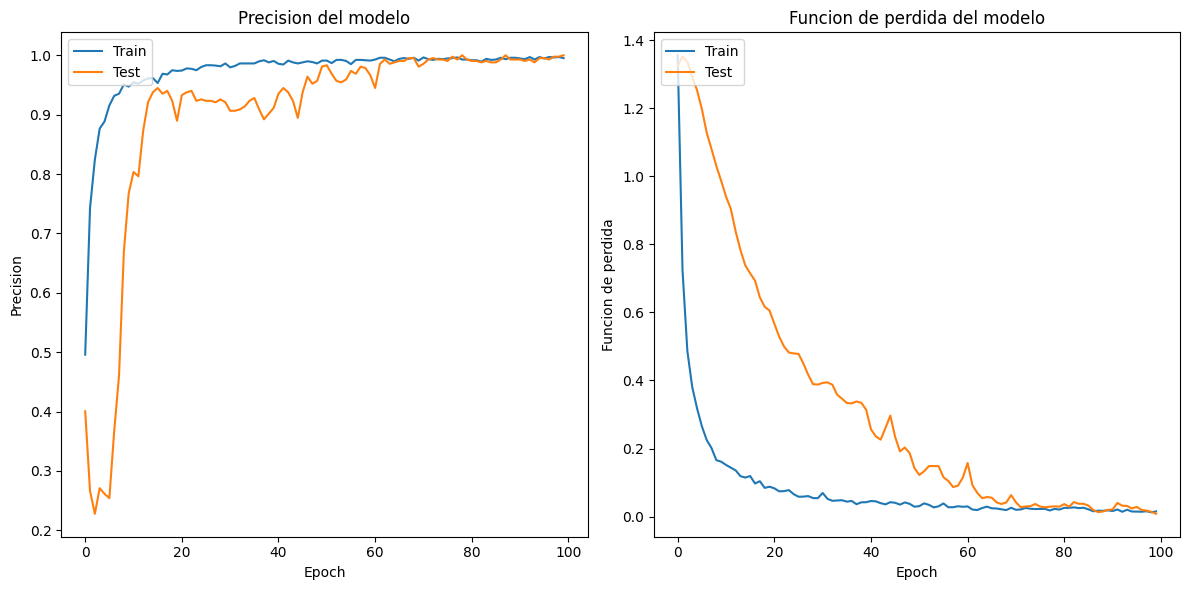

In [1]:
from scripts.Entrenamiento import Modelo
model=Modelo()
model.cargar_datos()
model.dividir_datos()
model.construccion()
history=model.entrenamiento()
model.evaluacion()
model.graficar_entrenamiento(history)

## 📊 3. Evaluación y Comparativa de Modelos Guardados

En esta sección se cargan y evalúan los **modelos previamente entrenados** al ejecutar la celda anterior, esto con el objetivo de:

- 📌 **Seleccionar el mejor modelo** para futuras predicciones.
- 🗑️ **Descartar modelos** que no alcancen un rendimiento aceptable.
- 📈 **Comparar** métricas clave de desempeño para una toma de decisión informada.

### 🔍 Flujo del proceso
1. **Localización de modelos**:  
   Se buscan en la carpeta `models/` todos los archivos con nombre `best_model*.keras`.
2. **Carga y evaluación**:  
   Cada modelo se carga con `load_model` y se evalúa contra el *test set* (`X_test`, `Y_oh_test`), obteniendo:
   - **Loss** (función de pérdida en test).
   - **Accuracy** en el conjunto de prueba.
3. **Generación de predicciones**:  
   Se predicen las clases del *test set*.
4. **Matriz de confusión (`confusion_matrix`)**:  
   Permite visualizar los aciertos y errores por clase.
5. **Reporte de clasificación (`classification_report`)**:  
   Incluye precisión (*precision*), exhaustividad (*recall*) y F1-score por clase.

### 📈 Interpretación esperada
- **Modelo ideal para predicción**:  
  Aquel con **alta precisión** y **balance entre clases** (sin que una clase en particular sea mucho peor).
- **Modelo candidato a descartar**:  
  Rendimiento notablemente inferior o métricas muy desequilibradas entre clases.


In [2]:
from pathlib import Path
from keras.models import load_model
from sklearn.metrics import confusion_matrix, classification_report
X_test,Y_test,poses_lb=model.getX_test_Y_test_poses_lb()
model_path = Path ("models").resolve()
models = [p for p in model_path.rglob("best_model*.keras")]
for model in models:
    modelName=str(model)
    print(f'\n\n Modelo: {model.stem}')
    best_model = load_model(modelName)
    test_loss, test_acc = best_model.evaluate(X_test, Y_test, verbose=0)
    print(f"Accuracy en test: {test_acc:.3f}")


    y_pred = best_model.predict(X_test)
    cm = confusion_matrix(Y_test.argmax(1), y_pred.argmax(1))
    print(cm)
    print(classification_report(Y_test.argmax(1), y_pred.argmax(1), target_names=poses_lb.classes_))



 Modelo: best_model_7
Accuracy en test: 0.956
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
[[352   2   0   0]
 [  5 378   0   0]
 [  2  28 457   0]
 [ 15   4   9 214]]
                 precision    recall  f1-score   support

BRAZOS_CRUZADOS       0.94      0.99      0.97       354
         FIRMES       0.92      0.99      0.95       383
           OTRO       0.98      0.94      0.96       487
 POSICION_FETAL       1.00      0.88      0.94       242

       accuracy                           0.96      1466
      macro avg       0.96      0.95      0.95      1466
   weighted avg       0.96      0.96      0.96      1466



 Modelo: best_model_25
Accuracy en test: 0.954
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
[[337  17   0   0]
 [  0 383   0   0]
 [  2  25 457   3]
 [ 17   2   2 221]]
                 precision    recall  f1-score   support

BRAZOS_CRUZADOS       0.95      0.95      0.95       354
         FIRMES       0.90      1.00      0.95       383
           OTRO       1.00      0.94    